In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import scipy.stats
from gprofiler import GProfiler
import pickle
from adjustText import adjust_text
from matplotlib import gridspec
# Other specific functions 
from itertools import product
from statsmodels.stats.multitest import multipletests
import time
import os

import sys
sys.path.insert(1, '../')
import util

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.11.0


In [2]:
# GLOBAL VARIABLES
DATA_PATH = '/n/groups/price/martin/tms_gene_data'
DGE_RES_PATH = DATA_PATH + '/DGE_result'
DGE_RES_PATH_OLD = DATA_PATH + '/DE_result_old'
ANNO_DATA_PATH = DATA_PATH + '/annotation_data'
RESULT_PATH = DATA_PATH + '/result_v1'

METHOD_LIST = ['facs', 'droplet']
DIC_METHOD_NAME = {'facs':'FACS', 'droplet':'droplet'}
CELLCATE_LIST = ['immune', 'stem cell/progenitor', 'stromal', 'endothelial', 'epithelial', 'parenchymal']

### Load data

In [3]:
# Load the data obs df: facs
temp_data = util.load_normalized_data(DATA_PATH, data_name='facs', total_ct_per_cell=1e4,
                                      flag_size_factor=False, flag_log1p=False)
gene_list_facs = list(temp_data.var_names)
gene_list_facs.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_facs = temp_data.obs.copy()
df_obs_facs['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_obs_facs['tissue'],
                                                       df_obs_facs['cell_ontology_class'])]

# Load the data obs df: droplet
temp_data = util.load_normalized_data(DATA_PATH, data_name='droplet',
                                      flag_size_factor=False, flag_log1p=False)
gene_list_droplet = list(temp_data.var_names)
gene_list_droplet.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_droplet = temp_data.obs.copy()
df_obs_droplet['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_obs_droplet['tissue'], 
                                                          df_obs_droplet['cell_ontology_class'])]

# Load the data obs df: bulk
temp_data = util.load_normalized_data_bulk(DATA_PATH, flag_size_factor=False, flag_log1p=False)
gene_list_bulk = list(temp_data.var_names)
gene_list_bulk.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_bulk = temp_data.obs.copy()
df_obs_bulk['analyte'] = df_obs_bulk['tissue']

# dic for obs
dic_obs = {'facs':df_obs_facs, 'droplet':df_obs_droplet, 'bulk':df_obs_bulk}
dic_gene_list = {'facs':gene_list_facs, 'droplet':gene_list_droplet, 'bulk':gene_list_bulk}

# del temp results
del temp_data

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [4]:
# Get n_erccs
temp_data=read_h5ad(DATA_PATH+'/adata_with_ercc_gatk_all_data_with_metadata.h5ad')
ercc_list = [x for x in temp_data.var_names if 'ERCC' in x]
temp_data.obs['n_ercc_counts'] = temp_data[:,ercc_list].X.sum(axis=1)
temp_data.obs['n_erccs'] = (temp_data[:,ercc_list].X>0).sum(axis=1)

temp_df = temp_data.obs.copy()
temp_df.index = temp_df['cell']
temp_df = temp_df.loc[dic_obs['facs']['cell']]
dic_obs['facs']['n_ercc_counts'] = temp_df['n_ercc_counts'].values
dic_obs['facs']['n_erccs'] = temp_df['n_erccs'].values

del temp_data
del temp_df

### Load DGE results

In [5]:
# Load DGE results
version_list = ['1e4', 'n_gene', 'male_only', 'male_only.3_vs_18', 'female_only']
dic_dge = {}

for version in version_list:
    df_info_facs,dic_dge_facs = util.load_DGE_res(DATA_PATH, dname='facs.tc', version=version)
    df_info_droplet,dic_dge_droplet = util.load_DGE_res(DATA_PATH, dname='droplet.tc', version=version)

    # Change analyte name
    temp_list = list(dic_dge_facs.keys())
    for analyte in temp_list:
        tissue,cell_type = analyte.split('.')
        cell_type = cell_type.replace('_', ' ')
        dic_dge_facs['%s.%s'%(tissue,cell_type)] = dic_dge_facs[analyte].copy()
        if '%s.%s'%(tissue,cell_type) != analyte: del dic_dge_facs[analyte]

    temp_list = list(dic_dge_droplet.keys())
    for analyte in temp_list:
        tissue,cell_type = analyte.split('.')
        cell_type = cell_type.replace('_', ' ')
        dic_dge_droplet['%s.%s'%(tissue,cell_type)] = dic_dge_droplet[analyte].copy()
        if '%s.%s'%(tissue,cell_type) != analyte:  del dic_dge_droplet[analyte]
        
    # fixit: update bh_p (not sure if this is necessary)
    if version=='1e4':
        dic_dge['facs'] = dic_dge_facs.copy()
        dic_dge['droplet'] = dic_dge_droplet.copy()
    else:
        dic_dge['facs.%s'%version] = dic_dge_facs.copy()
        dic_dge['droplet.%s'%version] = dic_dge_droplet.copy()
        
# Append tissue-level results
df_info_facs_tissue,dic_dge['facs.tissue'] = util.load_DGE_res(DATA_PATH, dname='facs.tissue', version='1e4')
df_info_droplet_tissue,dic_dge['droplet.tissue'] = util.load_DGE_res(DATA_PATH, dname='droplet.tissue',
                                                                     version='1e4')
df_info_bulk_tissue,dic_dge['bulk.tissue'] = util.load_DGE_res(DATA_PATH, dname='bulk.tissue', version='1e4')

84, Mammary_Gland.basal_cell.csv missing
85, Mammary_Gland.luminal_epithelial_cell_of_mammary_gland.csv missing
86, Mammary_Gland.stromal_cell.csv missing
42, Mammary_Gland.B_cell.csv missing
43, Mammary_Gland.T_cell.csv missing
44, Mammary_Gland.basal_cell.csv missing
45, Mammary_Gland.endothelial_cell.csv missing
46, Mammary_Gland.luminal_epithelial_cell_of_mammary_gland.csv missing
47, Mammary_Gland.macrophage.csv missing
48, Mammary_Gland.stromal_cell.csv missing
38, Heart.ventricular_myocyte.csv missing
84, Mammary_Gland.basal_cell.csv missing
85, Mammary_Gland.luminal_epithelial_cell_of_mammary_gland.csv missing
86, Mammary_Gland.stromal_cell.csv missing
1, Bladder.bladder_cell.csv missing
2, Bladder.bladder_urothelial_cell.csv missing
3, Bladder.endothelial_cell.csv missing
4, Bladder.leukocyte.csv missing
5, Heart_and_Aorta.endocardial_cell.csv missing
6, Heart_and_Aorta.endothelial_cell_of_coronary_artery.csv missing
7, Heart_and_Aorta.fibroblast_of_cardiac_tissue.csv missing


In [6]:
# dic_analysis_list and dic_fdr_threshold

# analysis list: facs
min_cell_number = 100
ind_select = (df_info_facs['n_cell_young']>min_cell_number) & (df_info_facs['n_cell_old']>min_cell_number)
analysis_list_facs = list(df_info_facs.index[ind_select])

# analysis list: droplet
min_cell_number = 500
ind_select = (df_info_droplet['n_cell_young']>min_cell_number) & (df_info_droplet['n_cell_old']>min_cell_number)
analysis_list_droplet = list(df_info_droplet.index[ind_select])

dic_analysis_list = {'facs':analysis_list_facs, 'droplet':analysis_list_droplet}
for method in METHOD_LIST:
    print('%s, n_tc=%d'%(method, len(dic_analysis_list[method])))

# thresholds parameters
coef_threshold = 0.005
dic_fdr_threshold = {'facs':0.01, 'droplet':0.01, 'bulk':0.1}

facs, n_tc=76
droplet, n_tc=26


In [7]:
# Structured DGE results
dic_H_p = {}
dic_H_fdr = {}
dic_coef = {}
dic_coef_z = {}
dic_coef_se = {}
dic_coef_p = {}
dic_coef_fdr = {}

for method in METHOD_LIST:
    for version in version_list:
        
        keyname=method if version=='1e4' else '%s.%s'%(method,version)
    
        dic_H_p[keyname] = pd.DataFrame(index = dic_gene_list[method])
        dic_H_fdr[keyname] = pd.DataFrame(index = dic_gene_list[method])
        dic_coef[keyname] = pd.DataFrame(index = dic_gene_list[method])
        dic_coef_z[keyname] = pd.DataFrame(index = dic_gene_list[method])
        dic_coef_se[keyname] = pd.DataFrame(index = dic_gene_list[method])

        dic_coef_p[keyname] = pd.DataFrame(index = dic_gene_list[method])
        dic_coef_fdr[keyname] = pd.DataFrame(index = dic_gene_list[method])

        for analyte in dic_analysis_list[method]:
            
            if analyte not in dic_dge[keyname].keys(): 
                dic_H_p[keyname][analyte] = 1
                dic_H_fdr[keyname][analyte] = 1
                dic_coef[keyname][analyte] = 0
                dic_coef_z[keyname][analyte] = 0
                dic_coef_se[keyname][analyte] = 1e6
                dic_coef_p[keyname][analyte] = 1
                dic_coef_fdr[keyname][analyte] = 1
                continue
                

            dic_H_p[keyname][analyte] = dic_dge[keyname][analyte]['age.H_p']
            dic_H_fdr[keyname][analyte] = dic_dge[keyname][analyte]['age.H_fdr']
            dic_coef[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC']
            dic_coef_z[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC_z']
            dic_coef_se[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC']/\
                                            dic_dge[keyname][analyte]['age.logFC_z']

            temp_v = dic_dge[keyname][analyte]['age.logFC_z']
            temp_gene_list = list(dic_dge[keyname][analyte].index)
            temp_v_p = (1-sp.stats.norm.cdf(np.absolute(temp_v)))*2
            temp_v_p[np.isnan(temp_v_p)] = 1
            temp_v_fdr = multipletests(temp_v_p, method='fdr_bh')[1]

            dic_coef_p[keyname].loc[temp_gene_list, analyte] = temp_v_p
            dic_coef_fdr[keyname].loc[temp_gene_list, analyte] = temp_v_fdr

        # na values
        dic_H_p[keyname] = dic_H_p[keyname].fillna(1)
        dic_H_fdr[keyname] = dic_H_fdr[keyname].fillna(1)
        dic_coef[keyname] = dic_coef[keyname].fillna(0)    
        dic_coef_z[keyname] = dic_coef_z[keyname].fillna(0)    
        dic_coef_se[keyname] = dic_coef_se[keyname].fillna(1e6)

        dic_coef_p[keyname] = dic_coef_p[keyname].fillna(1)
        dic_coef_fdr[keyname] = dic_coef_fdr[keyname].fillna(1)

/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


In [8]:
# Structured DGE results: append tissue-level results 
for method in ['facs', 'droplet', 'bulk']:
    
    tissue_list = list(dic_dge['%s.tissue'%method])
    tissue_list.sort()
    keyname = '%s.tissue'%method
        
    dic_H_p[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_H_fdr[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_z[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_se[keyname] = pd.DataFrame(index = dic_gene_list[method])

    dic_coef_p[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_fdr[keyname] = pd.DataFrame(index = dic_gene_list[method])

    for analyte in tissue_list:

        dic_H_p[keyname][analyte] = dic_dge[keyname][analyte]['age.H_p']
        dic_H_fdr[keyname][analyte] = dic_dge[keyname][analyte]['age.H_fdr']
        dic_coef[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC']
        dic_coef_z[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC_z']
        dic_coef_se[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC']/\
                                        dic_dge[keyname][analyte]['age.logFC_z']

        temp_v = dic_dge[keyname][analyte]['age.logFC_z']
        temp_gene_list = list(dic_dge[keyname][analyte].index)
        temp_v_p = (1-sp.stats.norm.cdf(np.absolute(temp_v)))*2
        temp_v_p[np.isnan(temp_v_p)] = 1
        temp_v_fdr = multipletests(temp_v_p, method='fdr_bh')[1]

        dic_coef_p[keyname].loc[temp_gene_list, analyte] = temp_v_p
        dic_coef_fdr[keyname].loc[temp_gene_list, analyte] = temp_v_fdr

    # na values
    dic_H_p[keyname] = dic_H_p[keyname].fillna(1)
    dic_H_fdr[keyname] = dic_H_fdr[keyname].fillna(1)
    dic_coef[keyname] = dic_coef[keyname].fillna(0)    
    dic_coef_z[keyname] = dic_coef_z[keyname].fillna(0)    
    dic_coef_se[keyname] = dic_coef_se[keyname].fillna(1e6)

    dic_coef_p[keyname] = dic_coef_p[keyname].fillna(1)
    dic_coef_fdr[keyname] = dic_coef_fdr[keyname].fillna(1)

### Load annotations

In [9]:
# df_cell_category
df_cell_category = pd.read_csv(ANNO_DATA_PATH + '/cell_ontology_class_functional_annotation.073020.tsv',
                               header=0, index_col=None, sep='\t')
df_cell_category = df_cell_category.fillna('')

df_cell_category['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_cell_category['tissue'],
                                                            df_cell_category['cell_ontology_class'])]
df_cell_category.index = df_cell_category['analyte']

df_cell_category = df_cell_category[['cell category', 'turnover_mouse', 'binary_lifespan',
                                     'binary_lifespan_ref (short<90day, long>180day)',
                                     'turnover_mouse', 'turnover_mouse_ref']]

In [10]:
# Analyte annotation
dic_anno = {}
for method in METHOD_LIST:
    for version in version_list:
        
        keyname=method if version=='1e4' else '%s.%s'%(method,version)
        dic_anno[keyname] = pd.DataFrame(index=dic_analysis_list[method])
        
         # tissue and cell_ontology_class
        dic_anno[keyname]['tissue'] = [x.split('.')[0] for x in dic_anno[keyname].index]
        dic_anno[keyname]['cell_ontology_class'] = [x.split('.')[1] for x in dic_anno[keyname].index]

        # n_cell
        dic_anno[keyname]['n_cell'] = [((dic_obs[method]['tissue']==x.split('.')[0]) & 
                                       (dic_obs[method]['cell_ontology_class']==x.split('.')[1])).sum() 
                                      for x in dic_anno[keyname].index]

        # n_celltype in the tissue
        temp_dic = {x:(dic_anno[keyname]['tissue']==x).sum() for x in set(dic_anno[keyname]['tissue'])}
        dic_anno[keyname]['n_celltype'] = [temp_dic[x] for x in dic_anno[keyname]['tissue']]

        # n_rej
        dic_anno[keyname]['n_rej'] = [np.sum((dic_H_fdr[keyname][x]<dic_fdr_threshold[method]) &
                                            (np.absolute(dic_coef[keyname][x])>coef_threshold))
                                     for x in dic_anno[keyname].index]

        dic_anno[keyname]['n_rej.up'] = [np.sum((dic_H_fdr[keyname][x]<dic_fdr_threshold[method]) &
                                               (dic_coef[keyname][x]>coef_threshold))
                                        for x in dic_anno[keyname].index]

        dic_anno[keyname]['n_rej.down'] = [np.sum((dic_H_fdr[keyname][x]<dic_fdr_threshold[method]) &
                                                 (dic_coef[keyname][x]<-coef_threshold))
                                          for x in dic_anno[keyname].index]


        dic_anno[keyname] = dic_anno[keyname].join(df_cell_category)
        
# Analyte annotation: tissue-level
for method in ['facs', 'droplet', 'bulk']:
    
    tissue_list = list(dic_dge['%s.tissue'%method])
    tissue_list.sort()
    keyname = '%s.tissue'%method
    dic_anno[keyname] = pd.DataFrame(index=tissue_list)
        
     # tissue and cell_ontology_class
    dic_anno[keyname]['tissue'] = [x for x in dic_anno[keyname].index]

    # n_cell
    dic_anno[keyname]['n_cell'] = [(dic_obs[method]['tissue']==x).sum() for x in dic_anno[keyname].index]
    
    # n_rej
    dic_anno[keyname]['n_rej'] = [np.sum((dic_H_fdr[keyname][x]<dic_fdr_threshold[method]) &
                                        (np.absolute(dic_coef[keyname][x])>coef_threshold))
                                  for x in dic_anno[keyname].index]

    dic_anno[keyname]['n_rej.up'] = [np.sum((dic_H_fdr[keyname][x]<dic_fdr_threshold[method]) &
                                           (dic_coef[keyname][x]>coef_threshold))
                                     for x in dic_anno[keyname].index]

    dic_anno[keyname]['n_rej.down'] = [np.sum((dic_H_fdr[keyname][x]<dic_fdr_threshold[method]) &
                                             (dic_coef[keyname][x]<-coef_threshold))
                                       for x in dic_anno[keyname].index]

### Summary table

In [34]:
# Data summary table
writer = pd.ExcelWriter(DATA_PATH+'/result_v1/tms_gene_table/data_summary.xlsx', engine='xlsxwriter')

# All analytes 
for method in METHOD_LIST:
    temp_list = list(set(dic_obs[method]['analyte']))
    temp_list.sort()
    age_list = list(set(dic_obs[method]['age_num']))
    age_list.sort()
    age_list = ['%dm'%x for x in age_list]
    df_table = pd.DataFrame(index=temp_list, columns=['tissue', 'cell_ontology_class', 'n_cell']+age_list)
    df_table['tissue'] = [x.split('.')[0] for x in df_table.index]
    df_table['cell_ontology_class'] = [x.split('.')[1] for x in df_table.index]
    for analyte in temp_list:
        temp_df = dic_obs[method].loc[dic_obs[method]['analyte']==analyte].copy()
        df_table.loc[analyte, 'n_cell'] = temp_df.shape[0]
        temp_df = temp_df.groupby('age').agg({'age_num':len})
        temp_v = temp_df.loc[age_list, 'age_num'].values
        temp_v[np.isnan(temp_v)] = 0
        df_table.loc[analyte, age_list] = np.array(temp_v, dtype=int)
    
    df_table['analyzed in the paper'] = 'no'
    df_table.loc[dic_analysis_list[method],'analyzed in the paper'] = 'yes'
    df_table.to_excel(writer, sheet_name='all %s tissue-cell'%DIC_METHOD_NAME[method], index=False)

dic_anno['facs'][['tissue', 'cell_ontology_class', 'n_cell', 'n_rej', 'n_rej.up', 'n_rej.down',
                  'cell category', 'binary_lifespan', 'binary_lifespan_ref (short<90day, long>180day)',
                  'turnover_mouse', 'turnover_mouse_ref']].to_excel(writer, sheet_name='76 TMS FACS tissue-cell', index=False)
dic_anno['droplet'][['tissue', 'cell_ontology_class', 'n_cell', 'n_rej', 'n_rej.up', 'n_rej.down',
                  'cell category', 'binary_lifespan', 'binary_lifespan_ref (short<90day, long>180day)',
                  'turnover_mouse', 'turnover_mouse_ref']].to_excel(writer, sheet_name='26 TMS droplet tissue-cell', index=False)
dic_anno['facs.tissue'][['tissue', 'n_cell', 'n_rej', 'n_rej.up',
                         'n_rej.down']].to_excel(writer, sheet_name='TMS FACS tissue', index=False)
dic_anno['droplet.tissue'][['tissue', 'n_cell', 'n_rej', 'n_rej.up',
                         'n_rej.down']].to_excel(writer, sheet_name='TMS droplet tissue', index=False)
dic_anno['bulk.tissue'][['tissue', 'n_cell', 'n_rej', 'n_rej.up',
                         'n_rej.down']].to_excel(writer, sheet_name='bulk tissue', index=False)
writer.save()


In [42]:
# DGE results tables 
writer = pd.ExcelWriter(DATA_PATH+'/result_v1/tms_gene_table/dge_summary.xlsx', engine='xlsxwriter')
for method in METHOD_LIST:
    df_table = pd.DataFrame(index=dic_gene_list[method], columns=dic_analysis_list[method], data=False)
    for analyte in dic_analysis_list[method]:
        gene_list = list(dic_H_fdr[method].index[(dic_H_fdr[method][analyte]<dic_fdr_threshold[method]) &
                                            (np.absolute(dic_coef[method][analyte])>coef_threshold)])
        df_table.loc[gene_list,analyte]=True
    df_table=df_table.loc[df_table.sum(axis=1)>0]
    df_table.to_excel(writer, sheet_name='TMS %s tissue-cell'%DIC_METHOD_NAME[method], index=True)
writer.save()

### Number of discoveries (./result_v1/fig_dge)

# facs            14/76 up regulation


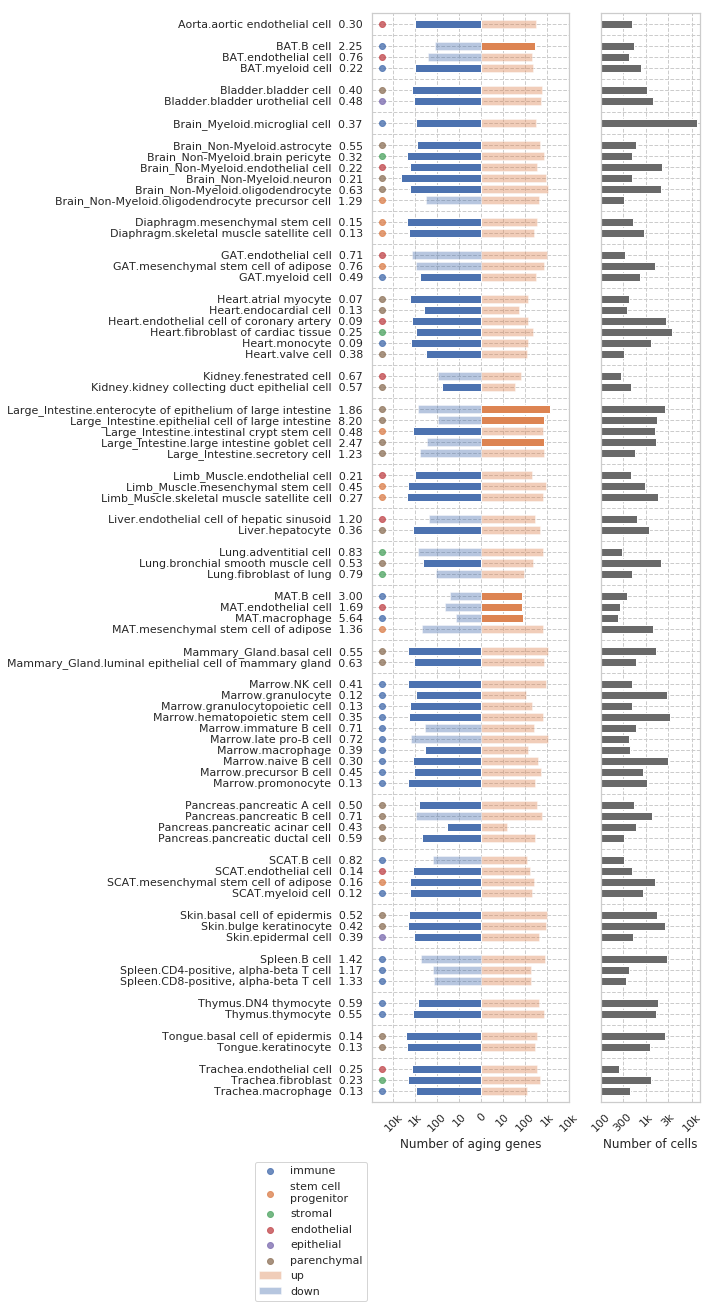

# facs.n_gene     35/76 up regulation


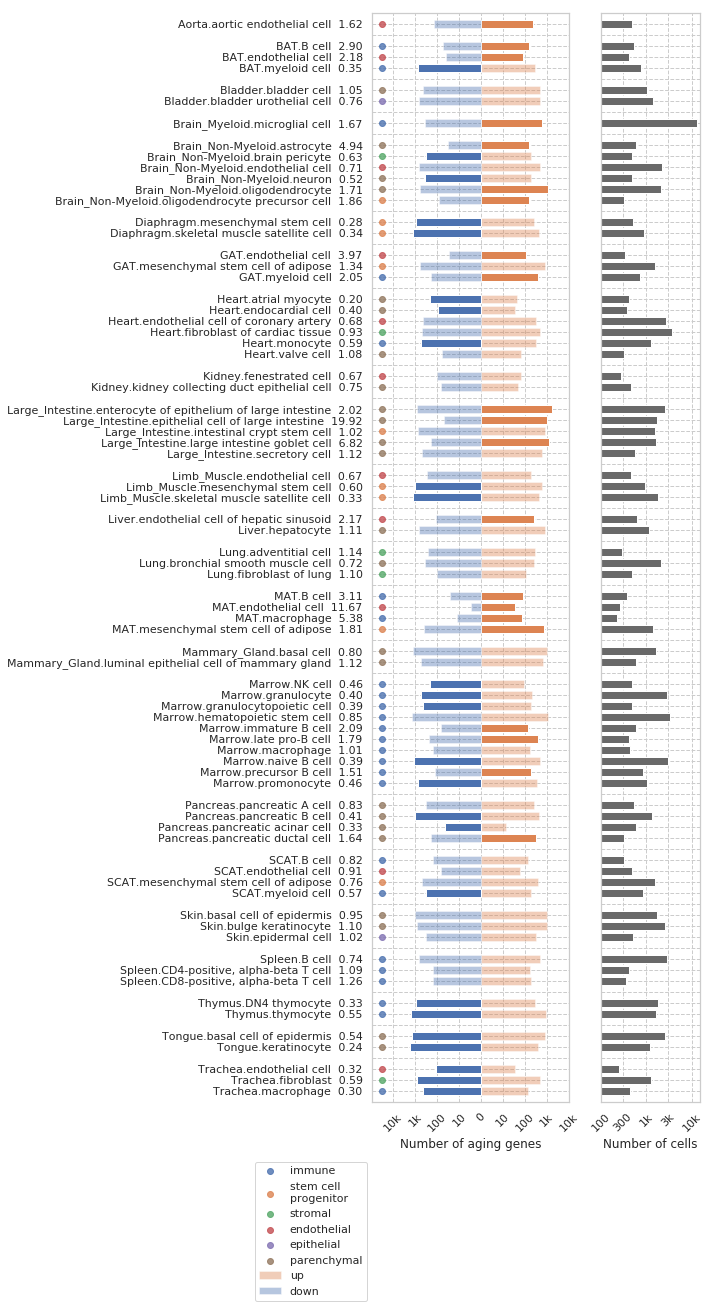

# facs.male_only  10/76 up regulation


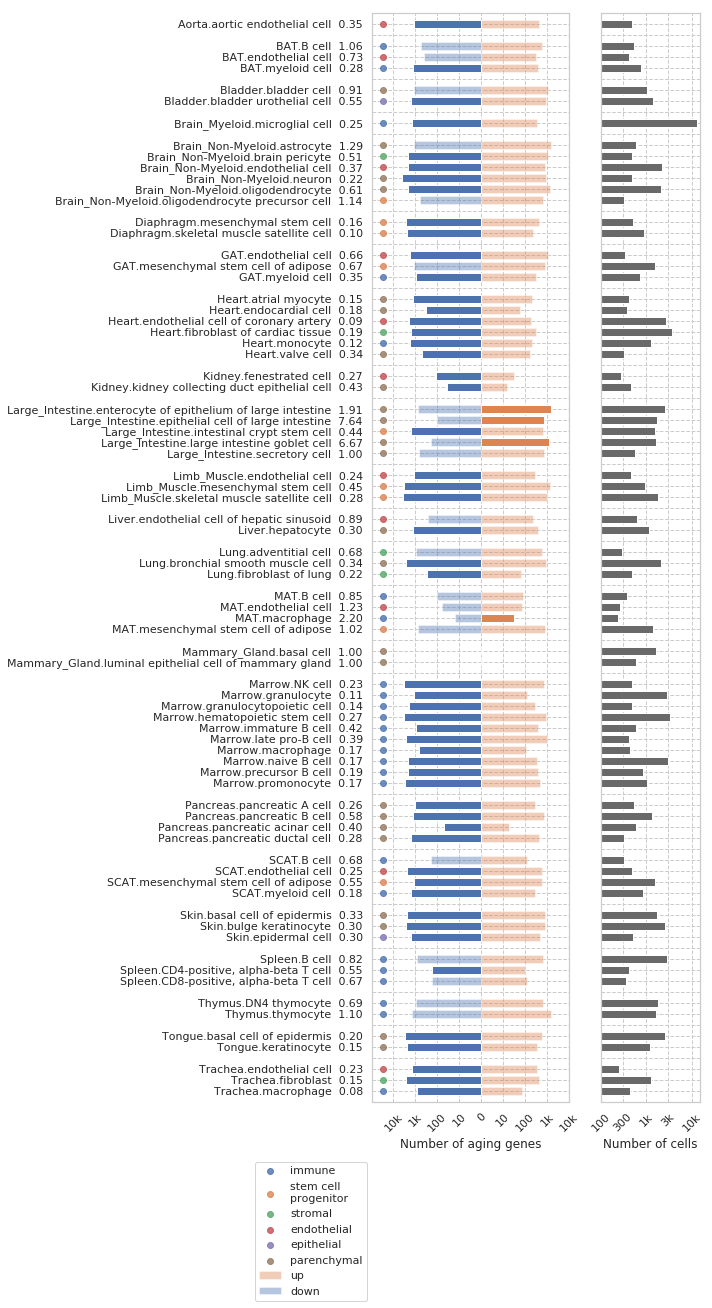

# facs.male_only.3_vs_18 41/76 up regulation


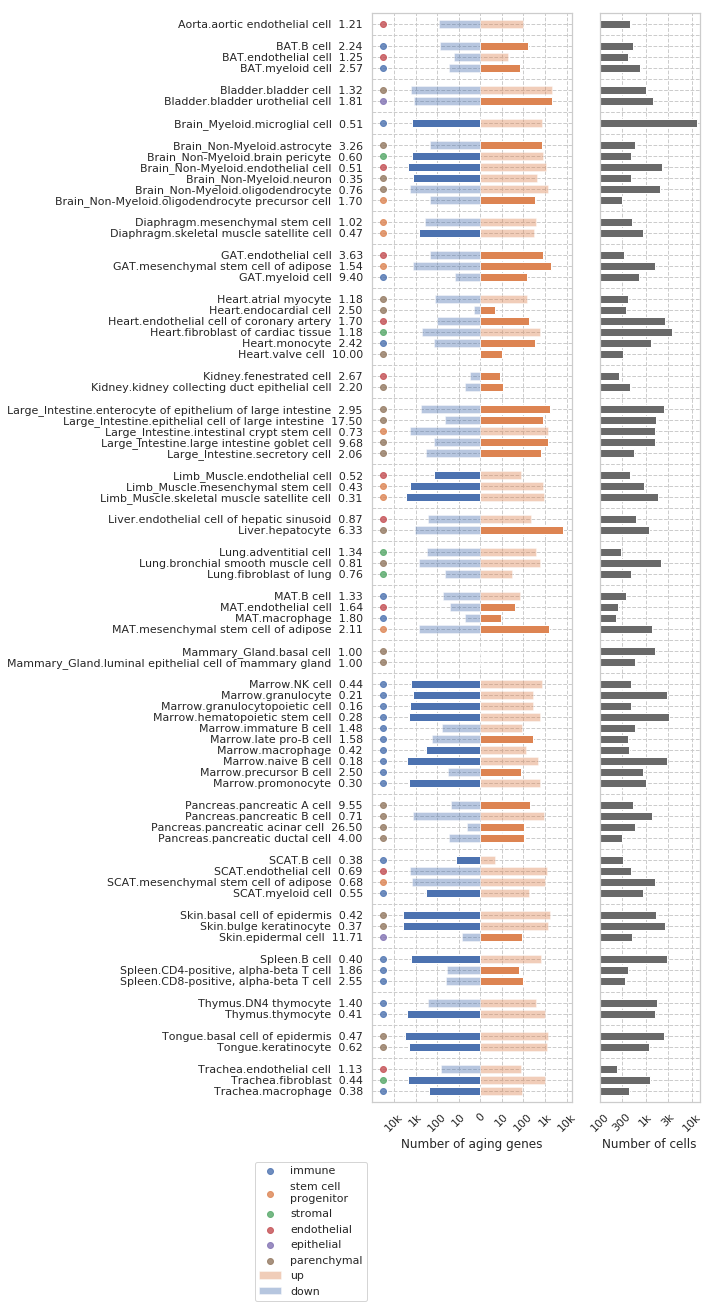

# facs.female_only 47/76 up regulation


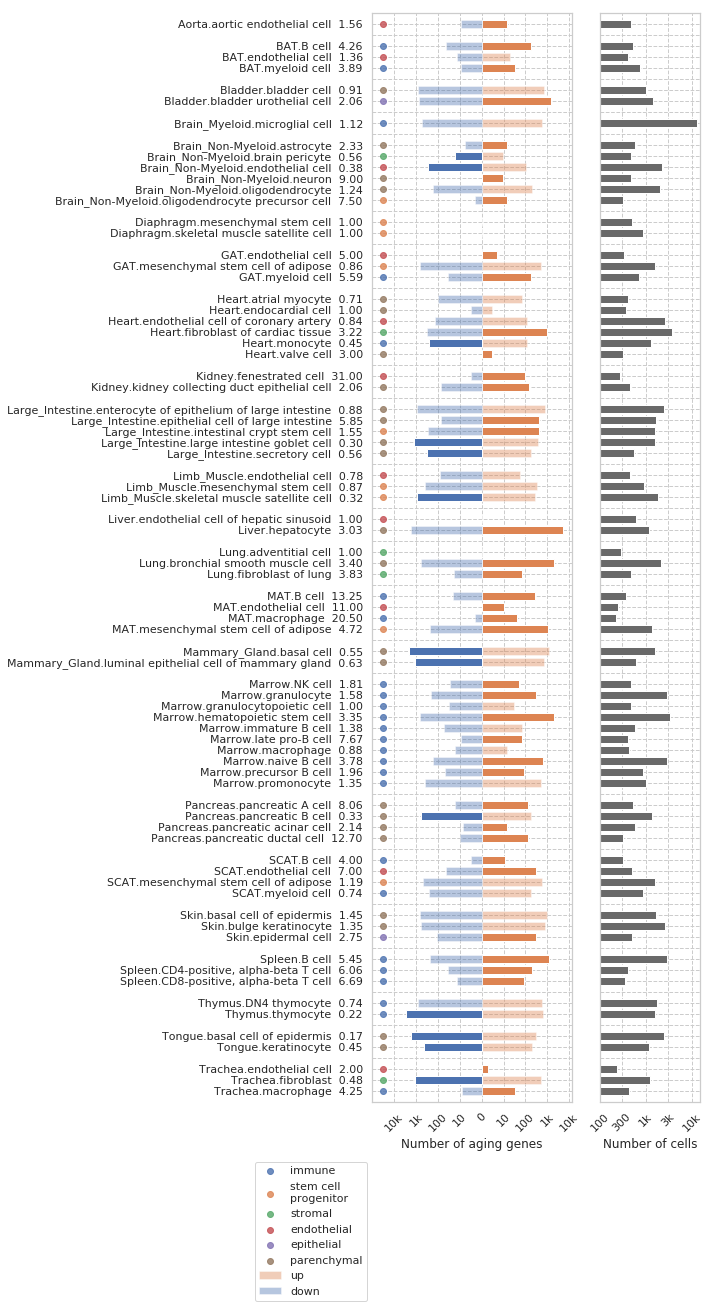

# facs.tissue     2/23 up regulation


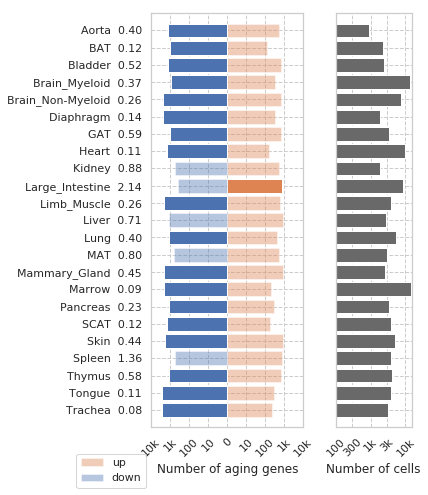

# droplet         7/26 up regulation


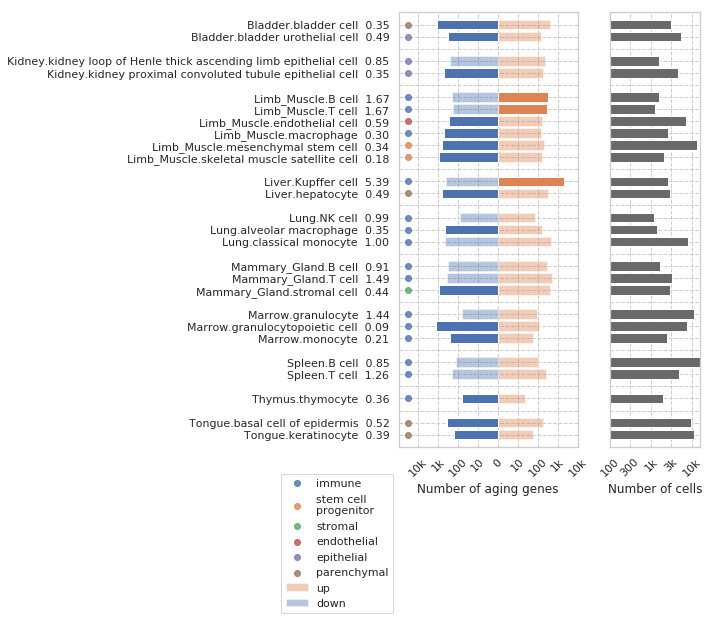

# droplet.n_gene  4/26 up regulation


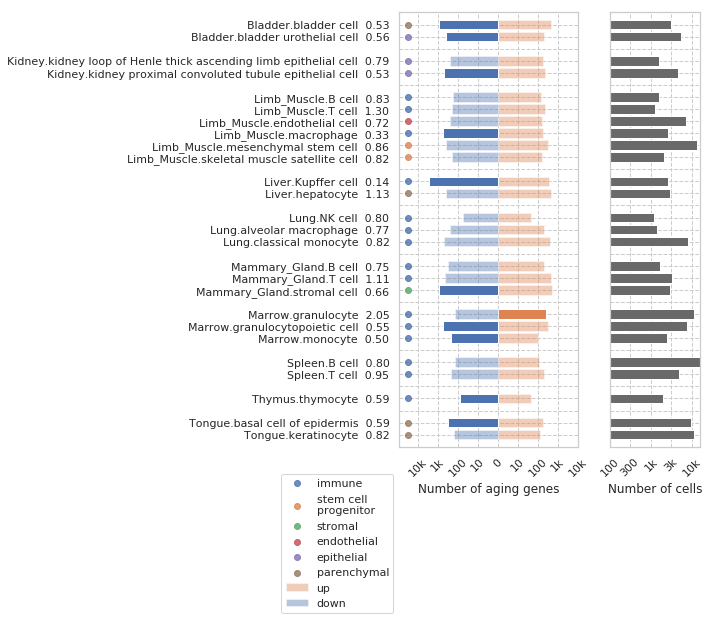

# droplet.male_only 3/26 up regulation


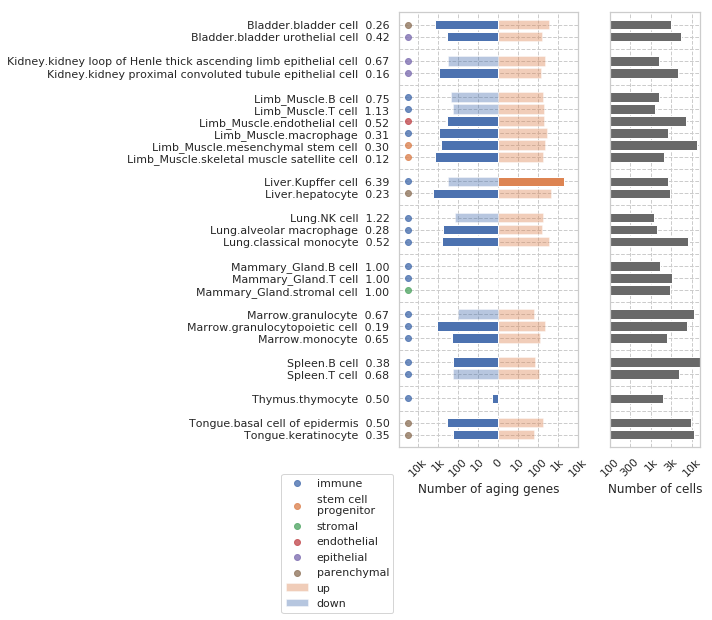

# droplet.male_only.3_vs_18 0/26 up regulation


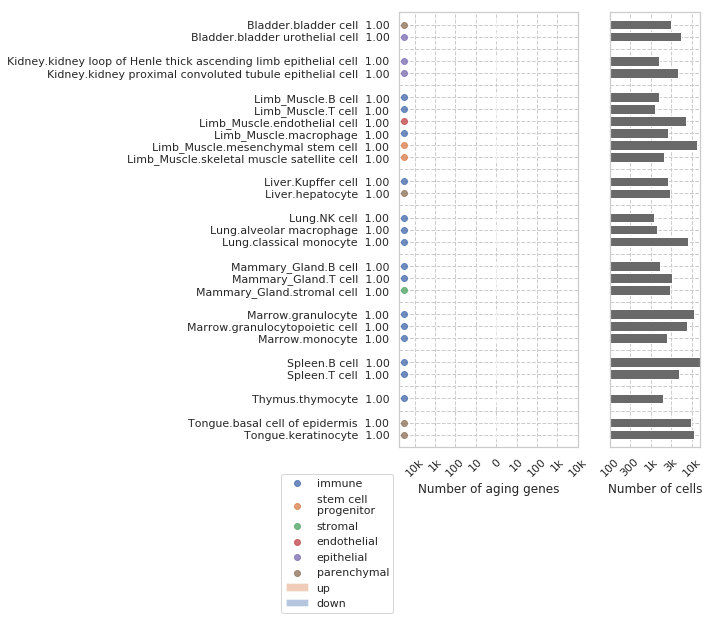

# droplet.female_only 9/26 up regulation


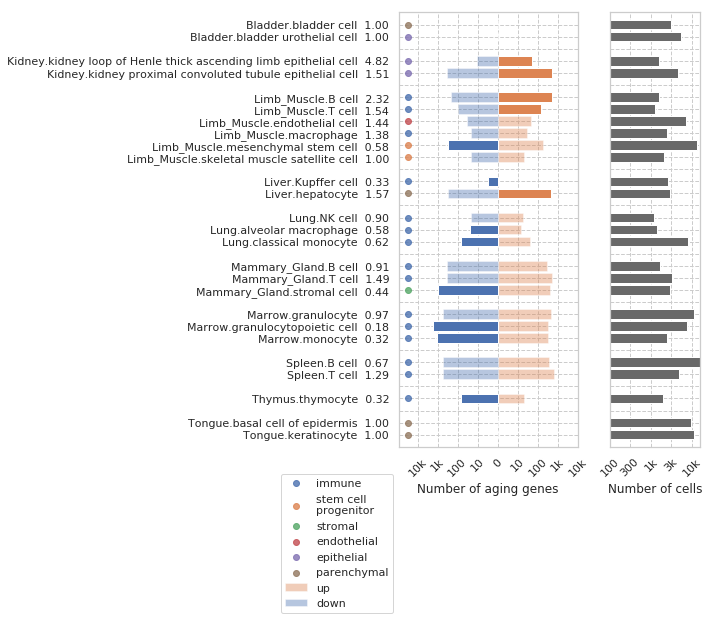

# droplet.tissue  1/11 up regulation


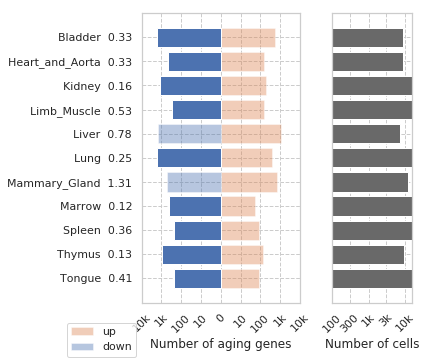

# bulk.tissue     6/17 up regulation


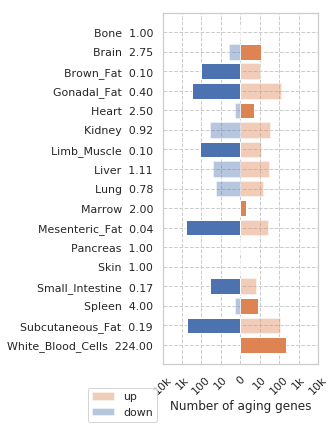

In [12]:
# Visualize the number of discoveries
for method in METHOD_LIST+['bulk']:
    for version in version_list+['tissue']:
        
        keyname=method if version=='1e4' else '%s.%s'%(method,version)
        if (method=='bulk')&(version!='tissue'): continue
            
        df_plot = dic_anno[keyname].copy()
        df_plot['n_rej.up'] = np.log10(df_plot['n_rej.up']+1)
        df_plot['n_rej.down'] = -np.log10(df_plot['n_rej.down']+1)
        df_plot['up/down'] = 10**(df_plot['n_rej.up']+df_plot['n_rej.down'])
        df_plot['tissue'] = [x.split('.')[0] for x in df_plot.index]
        df_plot['n_cell'] = np.log10(df_plot['n_cell'])
        ind_select = df_plot['n_rej.up']>np.absolute(df_plot['n_rej.down'])
        print('# %-15s %d/%d up regulation'%(keyname, np.sum(ind_select),  df_plot.shape[0]))

        # df_plot with enpty line between tissues
        tissue_list = list(set(df_plot['tissue']))
        tissue_list.sort()
        df_place_holder = pd.DataFrame(columns = df_plot.columns, index=[''], data=np.nan)

        temp_plot_df = pd.DataFrame(columns = df_plot.columns)
        for i_tissue,tissue in enumerate(tissue_list):
            temp_plot_df = temp_plot_df.append(df_plot.loc[df_plot['tissue']==tissue])
            if (i_tissue < len(tissue_list)-1)&(version!='tissue'):
                temp_plot_df = temp_plot_df.append(df_place_holder)
        temp_plot_df['loc'] = np.arange(temp_plot_df.shape[0])[::-1]
        temp_plot_df = temp_plot_df.iloc[::-1]

        # make figure 
        plt.figure(figsize=[10-4*(version=='tissue'), 3.5 + 0.15*temp_plot_df.shape[0]])
        gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

        plt.subplot(gs[0])
        
        ind_select = temp_plot_df['n_rej.up']>np.log10(1.5)+np.absolute(temp_plot_df['n_rej.down'])
        plt.barh(temp_plot_df.loc[ind_select, 'loc'],
                 temp_plot_df['n_rej.up'][ind_select], color='C1')
        plt.barh(temp_plot_df.loc[~ind_select, 'loc'],
                 temp_plot_df['n_rej.up'][~ind_select], alpha=0.4, label='up', color='C1')
        
        ind_select = temp_plot_df['n_rej.up']<-np.log10(1.5)+np.absolute(temp_plot_df['n_rej.down'])
        plt.barh(temp_plot_df.loc[ind_select, 'loc'],
                 temp_plot_df['n_rej.down'][ind_select], color='C0')
        plt.barh(temp_plot_df.loc[~ind_select, 'loc'],
                 temp_plot_df['n_rej.down'][~ind_select], alpha=0.4, label='down', color='C0')
        
        # Category annotation
        if version!='tissue':
            for i_cellcate,cellcate in enumerate(CELLCATE_LIST):
                ind_select = np.array([False if x=='' else 
                                       dic_anno[method].loc[x,'cell category'].split(';')[0]==cellcate
                                       for x in temp_plot_df.index])
                plt.scatter([-4.5]*ind_select.sum(), 
                            temp_plot_df.loc[ind_select, 'loc'], 
                            color='C%d'%i_cellcate, alpha=0.8, label=cellcate.replace('/', '\n'))
        
        x_tick = list(-np.log10([10000, 1000, 100, 10])) + [0] + \
                        list(np.log10([10, 100, 1000, 10000])) 
        plt.xticks(x_tick, ['10k', '1k', '100', '10', '0', '10', '100', '1k', '10k'], rotation=45, ha='center')
        temp_y_tick = ['%s  %0.2f'%(x,y) if len(x)>0 else x 
                       for x,y in zip(temp_plot_df.index, temp_plot_df['up/down']) ]
        plt.yticks(temp_plot_df['loc'], temp_y_tick)
        plt.ylim([-1, temp_plot_df.shape[0]])
        plt.grid(linestyle='--')
        plt.legend(bbox_to_anchor=(0,-0.05))
        plt.xlabel('Number of aging genes')
        
        if method!='bulk':
            plt.subplot(gs[1])
            plt.barh(temp_plot_df['loc'], temp_plot_df['n_cell'],
                     color='dimgray')
            x_tick = np.log10([100, 300, 1000, 3000, 10000])
            plt.xticks(x_tick, ['100', '300', '1k', '3k', '10k'], rotation=45, ha='center')
            plt.yticks(temp_plot_df['loc'], ['']*temp_plot_df.shape[0])
            plt.xlim([2, np.log10(15000)])
            plt.ylim([-1, temp_plot_df.shape[0]])
            plt.grid(linestyle='--')
            plt.xlabel('Number of cells')
        plt.tight_layout()
        plt.savefig(DATA_PATH+'/result_v1/fig_dge/n_discovery_%s.pdf'%(keyname))
        plt.show()
        
#         break
#     break

### Aging trajectory

In [13]:
# Load data
dic_data = {}
for method in METHOD_LIST:
    dic_data[method] = util.load_normalized_data(DATA_PATH, data_name=method, total_ct_per_cell=1e4,
                                                 flag_size_factor=True, flag_log1p=True)
    dic_data[method].obs['analyte'] = ['%s.%s'%(x,y) for x,y in zip(dic_data[method].obs['tissue'],
                                                                    dic_data[method].obs['cell_ontology_class'])]

Trying to set attribute `.obs` of view, copying.


In [14]:
from sklearn.cluster import KMeans

dic_traj = {x:None for x in METHOD_LIST}
dic_kmeans = {x:None for x in METHOD_LIST}
k_list = np.arange(2,21)

for method in METHOD_LIST:
    age_list = list(set(dic_data[method].obs['age_num'].values))
    age_list.sort()
    for analyte in dic_analysis_list[method]:
        gene_list = dic_H_fdr[method].index[(dic_H_fdr[method][analyte]<dic_fdr_threshold[method]) &
                                            (np.absolute(dic_coef[method][analyte])>coef_threshold)]
        temp_df = pd.DataFrame()
        temp_df['gene'] = gene_list
        temp_df['analyte'] = analyte
        for age in age_list:
            ind_select = (dic_data[method].obs['analyte'].values==analyte)&\
                            (dic_data[method].obs['age_num'].values==age)
            if ind_select.sum()>0:
                temp_df[age] = dic_data[method][ind_select, gene_list].X.mean(axis=0).T
            else:
                temp_df[age] = 0
        
        if dic_traj[method] is None:
            dic_traj[method] = temp_df.copy()
        else:
            dic_traj[method] = pd.concat([dic_traj[method], temp_df], axis=0)
        print(method, analyte)
#         break
        
    # Z-score 
    v_mean = np.array(dic_traj[method][age_list].mean(axis=1)).reshape([-1])
    v_std = np.array(dic_traj[method][age_list].std(axis=1)).reshape([-1])
    dic_traj[method][age_list] = ((dic_traj[method][age_list].values.T - v_mean)/v_std).T
    
    # K-means 
    dic_kmeans[method] = {x:{} for x in k_list}
    for k in k_list:
        mat_X = dic_traj[method][age_list].values.copy()
        kmeans = KMeans(n_clusters=k, random_state=0).fit(mat_X)
        dic_traj[method]['kmeans_%d'%k] = kmeans.labels_
        dic_kmeans[method][k]['score'] = kmeans.score(mat_X)
        dic_kmeans[method][k]['cluster_centers_'] = kmeans.cluster_centers_
    
#     break

facs Aorta.aortic endothelial cell
facs BAT.B cell
facs BAT.endothelial cell
facs BAT.myeloid cell
facs Bladder.bladder cell
facs Bladder.bladder urothelial cell
facs Brain_Myeloid.microglial cell
facs Brain_Non-Myeloid.astrocyte
facs Brain_Non-Myeloid.brain pericyte
facs Brain_Non-Myeloid.endothelial cell
facs Brain_Non-Myeloid.neuron
facs Brain_Non-Myeloid.oligodendrocyte
facs Brain_Non-Myeloid.oligodendrocyte precursor cell
facs Diaphragm.mesenchymal stem cell
facs Diaphragm.skeletal muscle satellite cell
facs GAT.endothelial cell
facs GAT.mesenchymal stem cell of adipose
facs GAT.myeloid cell
facs Heart.atrial myocyte
facs Heart.endocardial cell
facs Heart.endothelial cell of coronary artery
facs Heart.fibroblast of cardiac tissue
facs Heart.monocyte
facs Heart.valve cell
facs Kidney.fenestrated cell
facs Kidney.kidney collecting duct epithelial cell
facs Large_Intestine.enterocyte of epithelium of large intestine
facs Large_Intestine.epithelial cell of large intestine
facs Large_I

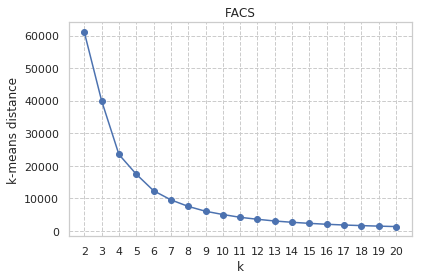

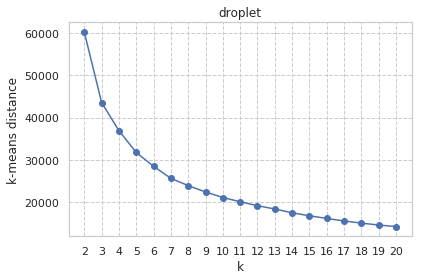

In [15]:
for method in METHOD_LIST:
    
    # kmeans loss
    df_plot = pd.DataFrame()
    df_plot['k'] = k_list
    df_plot['score'] = [-dic_kmeans[method][x]['score'] for x in k_list]
    
    plt.figure()
    plt.plot(df_plot['k'], df_plot['score'], ls='-', marker='o')
    plt.xticks(k_list,k_list)
    plt.grid(linestyle='--')
    plt.xlabel('k')
    plt.ylabel('k-means distance')
    plt.title(DIC_METHOD_NAME[method])
    plt.tight_layout()
    plt.savefig(DATA_PATH+'/result_v1/fig_dge/kmeans_loss_%s.pdf'%(method))
    plt.show()

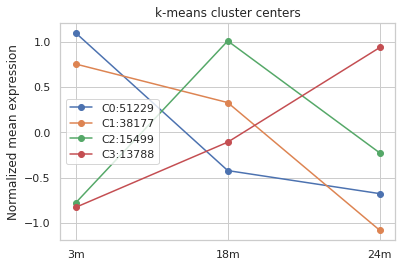

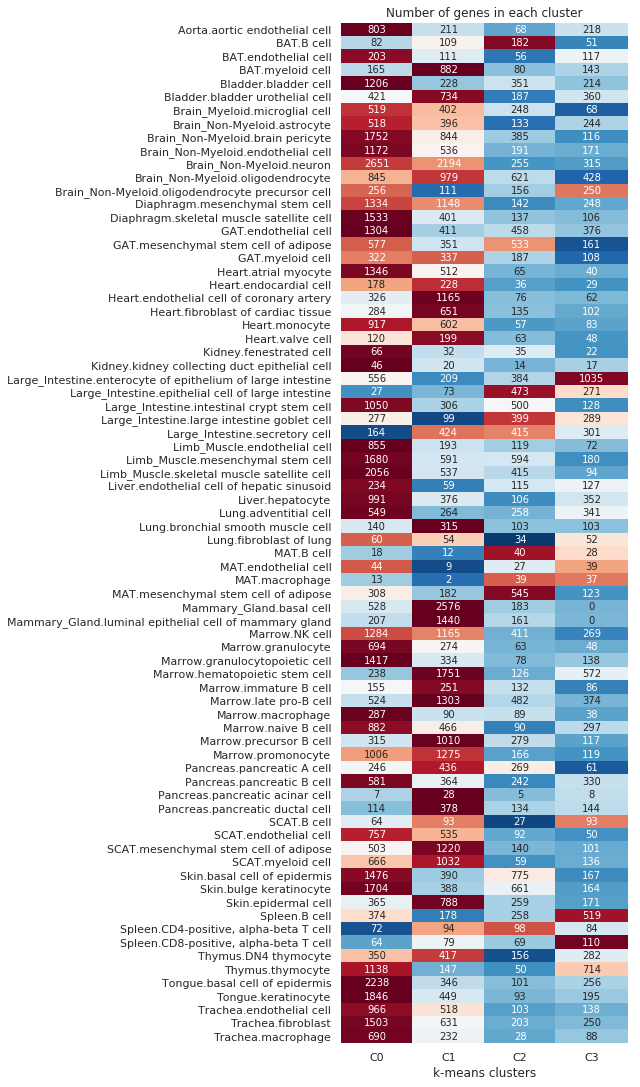

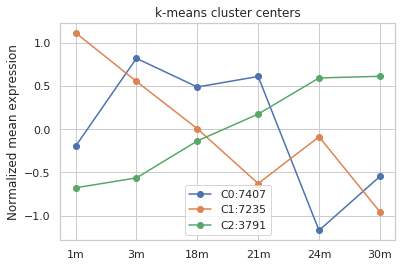

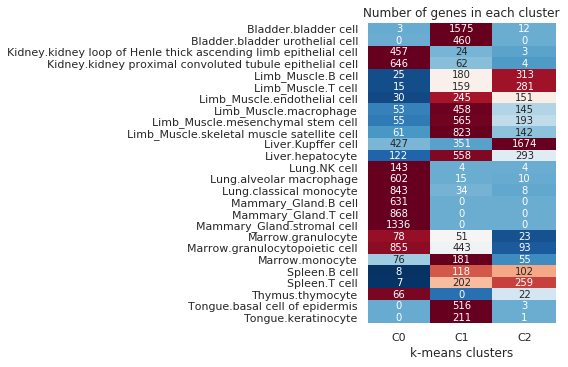

In [16]:
for method in METHOD_LIST:
    
    if method=='facs':
        k=4
    if method=='droplet':
        k=3
    
    age_list = list(set(dic_data[method].obs['age_num'].values))
    age_list.sort()
    
    # Overall analyte-genes
    plt.figure()
    
    df_plot = pd.DataFrame(dic_kmeans[method][k]['cluster_centers_'], columns=age_list)
    df_plot['n_gene'] = [(dic_traj[method]['kmeans_%d'%k]==i).sum() for i in np.arange(k)]
    df_plot['cluster'] = np.arange(k)
    df_plot = df_plot.sort_values(by='n_gene', ascending=False)
    df_plot.index = np.arange(k)
    df_plot['cluster_reorder'] = df_plot.index
    
    for i in np.arange(k):
        plt.plot(np.arange(len(age_list)), df_plot.loc[i,age_list], 
                 ls='-', marker='o', label='C%d:%d'%(i,df_plot.loc[i, 'n_gene']))
    plt.xticks(np.arange(len(age_list)), ['%dm'%x for x in age_list])
    plt.ylabel('Normalized mean expression')
    plt.legend()
    plt.title('k-means cluster centers')
    plt.savefig(DATA_PATH+'/result_v1/fig_dge/kmeans_cluster_center_%s.pdf'%(method),
                transparent=True, bbox_inches='tight')
    plt.show()
    
    # By tissue-cell type 
    df_plot_analyte = pd.DataFrame(index=dic_analysis_list[method],
                                   columns=['C%d'%x for x in np.arange(k)], data=0)
    for analyte in dic_analysis_list[method]:
        df_plot_analyte.loc[analyte] = [((dic_traj[method]['kmeans_%d'%k]==df_plot.loc[i,'cluster'])&
                                         (dic_traj[method]['analyte']==analyte)).sum()
                                        for i in np.arange(k)]
        
    df_annot = df_plot_analyte.copy()
    df_plot_analyte = ((df_plot_analyte.T-df_plot_analyte.mean(axis=1))/df_plot_analyte.std(axis=1)).T

    plt.figure(figsize = [df_plot_analyte.shape[1]+5, 0.2*df_plot_analyte.shape[0]])
    sns.heatmap(df_plot_analyte, annot=df_annot, fmt='d', xticklabels=True, yticklabels=True,
                cmap = 'RdBu_r', center=0, cbar=False)
    plt.xlabel('k-means clusters')

    plt.title('Number of genes in each cluster')
    plt.tight_layout()
    plt.savefig(DATA_PATH+'/result_v1/fig_dge/n_genes_kmeans_cluster_%s.pdf'%(method),
                transparent=True, bbox_inches='tight')
    plt.show()
    
    
#     break

### Compare DGE with CDR-corrected testing (./result_v1/fig_dge)

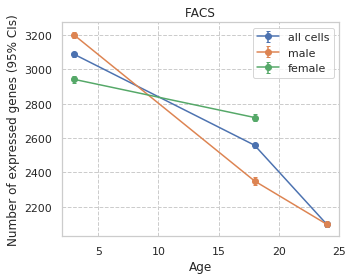

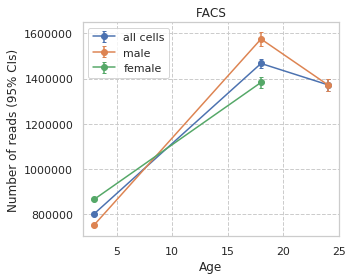

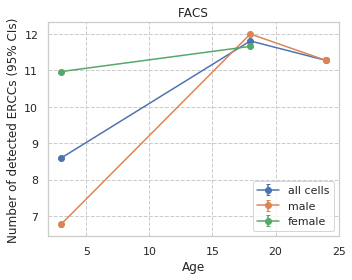

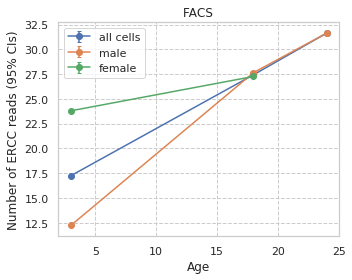

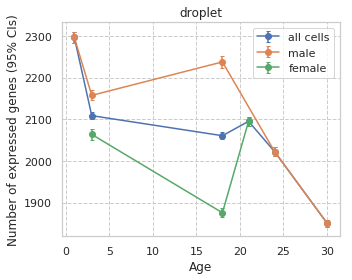

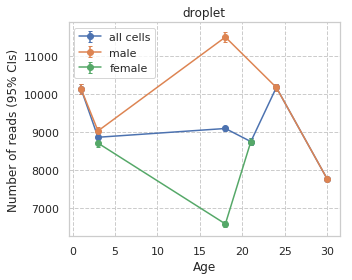

In [19]:
# CDR is correlated with age 
temp_dic_name = {'n_genes': 'expressed genes',
                 'n_counts': 'reads',
                 'n_erccs': 'detected ERCCs',
                 'n_ercc_counts': 'ERCC reads'}

for method in METHOD_LIST:
    for col in ['n_genes', 'n_counts', 'n_erccs', 'n_ercc_counts']:
        
        if (method=='droplet')&('ercc' in col): 
            continue
            
        plt.figure(figsize=[5,4])
        df_plot = dic_obs[method].groupby(['age_num']).agg({col:['mean','std', len]})
        df_plot.columns = ['mean', 'std', 'n_cell']
        plt.errorbar(df_plot.index, df_plot['mean'], 
                     yerr= 1.96*df_plot['std']/np.sqrt(df_plot['n_cell']),
                     fmt='-o', capsize=2, label='all cells')

        for sex in ['male', 'female']:
            ind_select = dic_obs[method]['sex']==sex        
            df_plot = dic_obs[method].loc[ind_select].groupby(['age_num']).agg({col:['mean','std', len]})
            df_plot.columns = ['mean', 'std', 'n_cell']
            plt.errorbar(df_plot.index, df_plot['mean'], 
                         yerr= 1.96*df_plot['std']/np.sqrt(df_plot['n_cell']),
                         fmt='-o', capsize=2, label=sex)

        plt.ylabel('Number of %s (95%% CIs)'%temp_dic_name[col])
        plt.xlabel('Age')
        plt.grid(linestyle='--')
        plt.title('%s'%DIC_METHOD_NAME[method])
        plt.legend()
        plt.tight_layout()
        plt.savefig(DATA_PATH+'/result_v1/fig_dge/%s_%s.pdf'%(col,method))
        plt.show()
#         break
#     break

# facs     corr=0.893 (std=0.079)


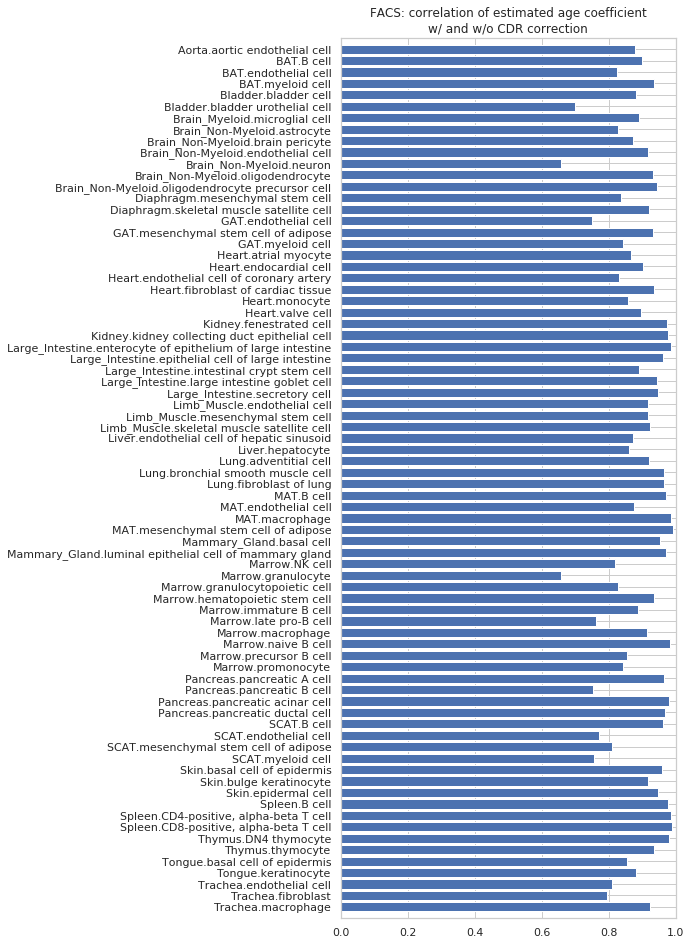

# droplet  corr=0.933 (std=0.117)


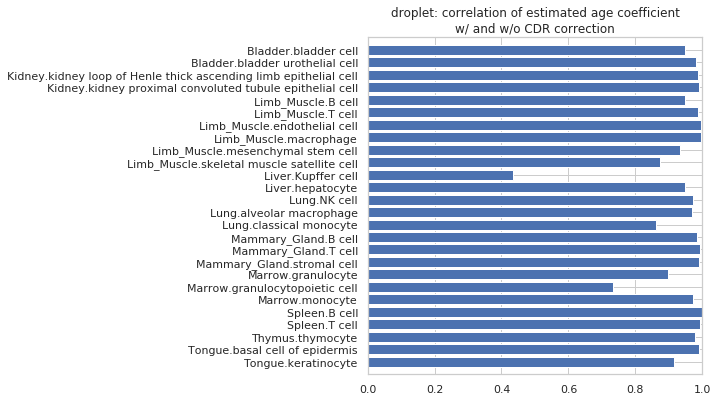

In [18]:
# Age coefficients between .1e4 and .n_gene 

for method in METHOD_LIST:
    df_plot = pd.DataFrame(index=dic_analysis_list[method],
                           columns=['corr'], data=0)
    for analyte in dic_analysis_list[method]:
        v1 = dic_coef['%s.n_gene'%(method)][analyte].values
        v2 = dic_coef['%s'%(method)][analyte].values
        ind_select = (v1!=0) & (v2!=0)
        df_plot.loc[analyte, 'corr'] = np.corrcoef(v1[ind_select], v2[ind_select])[0,1]
            
    df_plot['loc'] = np.arange(df_plot.shape[0])[::-1]
    
    print('# %-8s corr=%0.3f (std=%0.3f)'%(method, df_plot['corr'].mean(), df_plot['corr'].std()))
    
    plt.figure(figsize=[6, df_plot.shape[0]*0.2+1])
    plt.barh(df_plot['loc'], df_plot['corr'])
    plt.yticks(df_plot['loc'], df_plot.index, rotation=0)
    plt.xlim([0,1])
    plt.ylim([-1, df_plot.shape[0]])
    plt.title('%s: correlation of estimated age coefficient\nw/ and w/o CDR correction'
              %(DIC_METHOD_NAME[method]))
    plt.savefig(DATA_PATH+'/result_v1/fig_dge/corr_cdr_%s.pdf'%(method),
                transparent=True, bbox_inches='tight')
    plt.show()
        
        